# Machine learning for classification of galaxies in a cosmological simulation

#### Using k-nearest neighbors (KNN) method for developing an algorithm to classify dwarf and non-dwarf galaxies based on only the basic observed properties, i.e. the brightness in two bands.

In [7]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

## 1. Data

The data sample is obtained from the database of the Millennium Simulation (https://wwwmpa.mpa-garching.mpg.de/galform/virgo/millennium/).

Importing the data table using Pandas:

In [2]:
allData=pd.read_csv('non_type_2.csv')

#### The table contains 92 columns and more than 350,000 rows:

In [3]:
allData.shape

(352327, 92)

In [28]:
allData.head(10)

,fofID,haloid,mainLeafId,m_mean200,r_mean200,lastProgenitorId,nextProgenitorId,vDisp,vMax,vMaxRad,...,gDust,rDust,iDust,zDust,massweightedAge,uICL,gICL,rICL,iICL,zICL
0,670000001747,456000001000005519,456000001000005577,76.785034,0.236397,456000001000007487,-1,85.568720,145.260330,0.018912,...,-20.213880,-20.756542,-21.074020,-21.340120,7.249996,-11.071794,-12.246346,-12.796860,-13.034073,-13.148580
1,670000001747,456000001000003501,456000001000003557,76.785034,0.236397,456000001000005402,-1,78.947075,124.752400,0.042089,...,-19.573656,-20.226713,-20.585447,-20.882315,7.555652,-12.009012,-13.341147,-13.982567,-14.274243,-14.432263
2,670000001747,456000001000018384,456000001000018431,76.785034,0.236397,456000001000018437,-1,10.739923,21.803740,0.003675,...,-4.821945,-5.301389,-5.526311,-5.639255,12.424423,99.000000,99.000000,99.000000,99.000000,99.000000
3,670000001747,456000001000015307,456000001000015358,76.785034,0.236397,456000001000015366,-1,13.415302,28.816336,0.002104,...,-8.613350,-9.122391,-9.346907,-9.454640,12.205091,99.000000,99.000000,99.000000,99.000000,99.000000
4,670000001747,456000001000013105,456000001000013156,76.785034,0.236397,456000001000013156,-1,10.156959,21.776281,0.004184,...,-6.828017,-7.290368,-7.506182,-7.612974,11.429970,99.000000,99.000000,99.000000,99.000000,99.000000
5,670000001747,456000001000009680,456000001000009736,76.785034,0.236397,456000001000009768,-1,23.742100,48.597110,0.004250,...,-12.872231,-13.470244,-13.741811,-13.885711,10.406156,99.000000,99.000000,99.000000,99.000000,99.000000
6,670000001747,456000001000011342,456000001000011390,76.785034,0.236397,456000001000011447,-1,16.831890,32.949110,0.005973,...,-10.163651,-10.632000,-10.853534,-10.959784,8.693774,99.000000,99.000000,99.000000,99.000000,99.000000
7,670000001747,456000001000010067,456000001000010111,76.785034,0.236397,456000001000010131,-1,18.092154,33.732320,0.006037,...,-10.705704,-11.208602,-11.427444,-11.527368,9.396851,99.000000,99.000000,99.000000,99.000000,99.000000
8,670000001747,456000001000010238,456000001000010290,76.785034,0.236397,456000001000010328,-1,22.304173,43.605057,0.003940,...,-12.088338,-12.639964,-12.879429,-12.995824,10.540014,99.000000,99.000000,99.000000,99.000000,99.000000
9,670000001747,456000001000016688,456000001000016735,76.785034,0.236397,456000001000016754,-1,12.048663,23.797796,0.003399,...,-7.927839,-8.397065,-8.617732,-8.724284,9.764897,99.000000,99.000000,99.000000,99.000000,99.000000


Limiting the galaxies to those more massive than 10^6 solar mass. This would exclude the galaxies with mass very close to the resolution limit. The unit of the mass in the data table is 10^10 solar mass.

In [5]:
stellarMassLimited=allData[allData['stellarMass'] > 0.0001]

In [8]:
print 'min stellarMass= {:.5f}'.format(min(stellarMassLimited.stellarMass)), '*10^10 solarMass'
print 'max stellarMass={:.5f}'.format(max(stellarMassLimited.stellarMass)), '*10^10 solarMass'
print 'shape', stellarMassLimited.shape

min stellarMass= 0.00010 *10^10 solarMass
max stellarMass=7.96236 *10^10 solarMass
shape (78906, 92)


I want to use only the most basic observational measurements, i.e. the apparent brightness in r and g bands. For that, I get the restframe r and g band absolute magnitudes and will assume the (x,y,z)=(0,0,0) as the observer's position, therefore, I need the (x,y,z) coordinates as well.

In [9]:
magnitudes=stellarMassLimited[['type','r_mag','g_mag','x','y','z']]

## 2. Spatial distribution of the galaxies in the simulation box

Let's have a look at the spacial distribution of the galaxies in the simulation box.

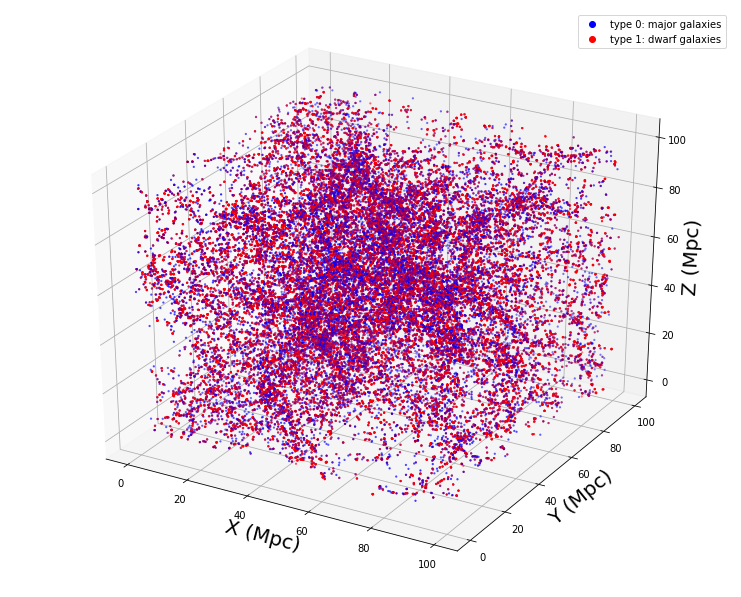

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)
sc=ax.scatter(magnitudes.x,magnitudes.y,magnitudes.z, c=magnitudes.type,s=5,edgecolor='none',cmap='bwr')
ax.set_xlabel('X (Mpc)',fontsize=20)
ax.set_ylabel('Y (Mpc)',fontsize=20)
ax.set_zlabel('Z (Mpc)',fontsize=20)

color0=np.where(magnitudes.type==0)[0][0]
color1=np.where(magnitudes.type==1)[0][0]
scatter1_proxy = plt.Line2D([0],[0], linestyle="none", c=sc.get_facecolor()[color0], marker = 'o')
scatter2_proxy = plt.Line2D([0],[0], linestyle="none", c=sc.get_facecolor()[color1], marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['type 0: major galaxies', 'type 1: dwarf galaxies'], numpoints = 1)

plt.show()

## 3. Converting the physical properties to observed properties

Assuming (x,y,z)=(0,0,0) as the observer's position, I transform the restframe absolute magnitudes to observed magnitudes using the relation

m=M+5*log10(d/Mpc)+25.


Note that the x,y, and z are in Mpc.

In [11]:
observedMagnitudes=magnitudes[['type','r_mag','g_mag','x','y','z']]

In [12]:
observedMagnitudes['r_mag']=observedMagnitudes.r_mag+25+5*np.log10(np.sqrt(observedMagnitudes.x**2+observedMagnitudes.y**2+observedMagnitudes.z**2))

In [13]:
observedMagnitudes['g_mag']=observedMagnitudes.g_mag+25+5*np.log10(np.sqrt(observedMagnitudes.x**2+observedMagnitudes.y**2+observedMagnitudes.z**2))

## 4. Selecting the relevant columns and adding some combinations

Now, a few combination of the basic properties, i.e. g-r, g+r, g*r, are also added to the data table as they might improve the classification algorithm.

In [18]:
finalTable=observedMagnitudes[['r_mag','g_mag']]
finalTarget=observedMagnitudes[['type']]

In [ ]:
finalTable['g_minus_r']=finalTable.g_mag-finalTable.r_mag
finalTable['g_plus_r']=finalTable.g_mag+finalTable.r_mag
finalTable['g_mult_r']=finalTable.g_mag*finalTable.r_mag
finalTable['g_over_r']=finalTable.g_mag/finalTable.r_mag

In [20]:
finalTable.head(5)

,r_mag,g_mag,g_minus_r,g_plus_r,g_mult_r,g_over_r
0,12.280373,12.712832,0.432459,24.993204,156.118307,1.035215
1,12.721495,13.181231,0.459736,25.902727,167.684972,1.036139
5,19.950791,20.548754,0.597963,40.499545,409.963906,1.029972
6,22.788030,23.256380,0.468350,46.044411,529.967100,1.020552
7,22.203208,22.706106,0.502898,44.909313,504.148376,1.022650


## 5. Using Scikit-learn

Dividing the data to training (80%) and test (20%) samples:

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(finalTable, finalTarget.type, test_size=0.2, random_state=0)


In [23]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (63124, 6)
y_train shape: (63124,)
X_test shape: (15782, 6)
y_test shape: (15782,)


### Visulising the pair-wise relation of the observed properties

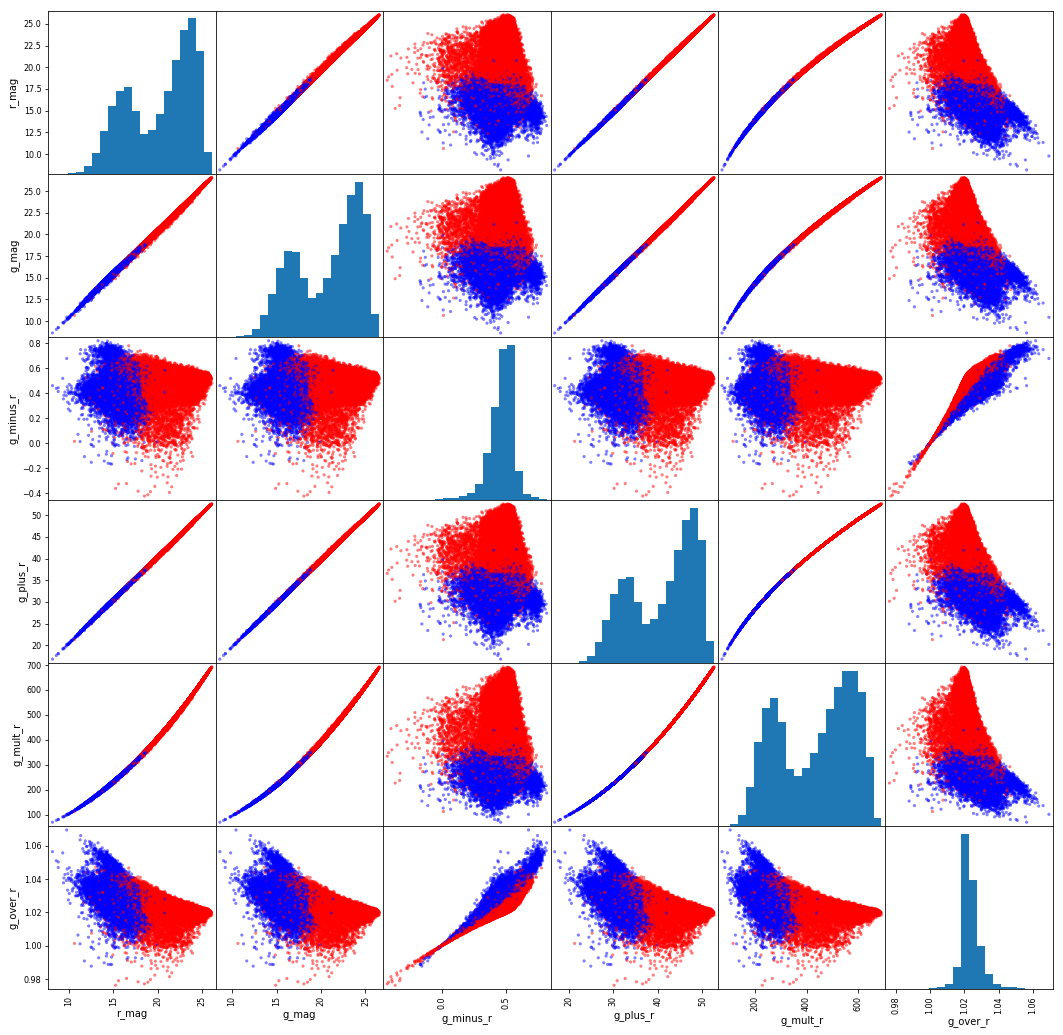

In [24]:
# create a scatter matrix from the dataframe, color by type
grr = pd.plotting.scatter_matrix(X_train, c=y_train, figsize=(18, 18), marker='o', 
                        hist_kwds={'bins': 20}, s=10, alpha=.5, cmap='bwr')

##  6. Using the KNN algorithm

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10,weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='distance')

In [26]:
knn.score(X_test, y_test)

0.9486757065010771

In [27]:
maxNeighbors=50
score=np.zeros(maxNeighbors)
for i in range(maxNeighbors):
    knn = KNeighborsClassifier(n_neighbors=i+1,weights='distance')
    knn.fit(X_train, y_train)
    score[i]=knn.score(X_test, y_test)

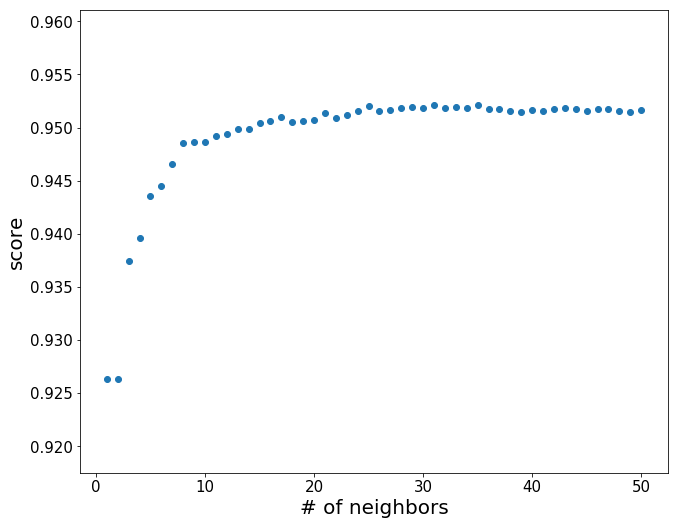

In [327]:
fig=plt.figure(figsize=(10,8))
neighbors=range(1,maxNeighbors+1)
plt.scatter(neighbors,score)
plt.xlabel("# of neighbors",size=20)
plt.ylabel("score",size=20)
plt.tight_layout(pad=3.5)
plt.tick_params(labelsize=15)

It seems that not much is gained by using beyond around 15 neighbors.

## This project is in progress ...